# Test problem from Caroe et al. (1999)

$$
\begin{align*}
\max_{x}      \quad & \frac{3}{2} x_1 + 4 x_2 + Q(x_1, x_2) \\
\mathrm{s.t.} \quad & 0 \leq x \leq 5 \\
                    & x \ \mathrm{integer}
\end{align*}
$$

where $Q(x_1,x_2)$:
$$
\begin{align*}
\max_{y}      \quad & 16 y_1 + 19 y_2 + 23 y_3 + 28 y_4 \\
\mathrm{s.t.} \quad & 2 y_1 + 3 y_2 + 4 y_3 + 5 y_4 \leq \zeta_1 - x_1 \\
                    & 6 y_1 + y_2 + 3 y_3 + 2 y_4 \leq \zeta_2 - x_2 \\
                    & y_i \in \{0,1\}
\end{align*}
$$
and $\zeta = (\zeta_1,\zeta_2)$ is uniformly distributed on
$$\Pi = \{(5,5), (5,6),\dots,(5,15),(6,5),\dots,(15,15)\}$$
giving 121 scenarios.

In [1]:
RELAX_LP = False

In [2]:
from __future__ import division
from cobra import Model
from dynamicme.optimize import Variable, Constraint
from six import iteritems
from dynamicme.decomposition.LagrangeMaster import LagrangeMaster
from dynamicme.decomposition.LagrangeSubmodel import LagrangeSubmodel
from dynamicme.decomposition.LagrangeBB import LagrangeBB

import numpy as np
import pandas as pd

In [3]:
zetas = [(i,j) for i in np.arange(5,16) for j in np.arange(5,16)]
print('Scenarios: %s'%len(zetas))

Scenarios: 121


In [4]:
probk = 1./len(zetas)  # Uniform probability over scenarios
cx = -np.array([3/2, 4])
fy = -np.array([16, 19, 23, 28])
xl = [0, 0]
xu = [5, 5]
A  = [[2,3,4,5],
      [6,1,3,2]]

sub_dict = {}
for k,zeta in enumerate(zetas):
    mdl = Model('sub')
    ys  = [Variable('y_%d'%j, lower_bound=0, upper_bound=1, objective_coefficient=fy[j]) for j in range(len(fy))]
    xs  = [Variable('x_%d'%j, lower_bound=xl[j], upper_bound=xu[j], objective_coefficient=cx[j]) for j in range(len(cx))]
    for x in xs:
        x.variable_kind = 'integer'
    for y in ys:
        y.variable_kind = 'integer'
    mdl.add_reactions(xs+ys)
    for i,ai in enumerate(A):
        cons = Constraint('cons_%d'%i)
        cons._constraint_sense = 'L'
        cons._bound = zeta[i]
        xs[i].add_metabolites({cons:1})
        for j,aij in enumerate(ai):
            ys[j].add_metabolites({cons:aij})
    sub_id = 'scen_%d'%k
    sub = LagrangeSubmodel(mdl, sub_id, first_stage_vars=xs)
    sub._weight = probk
    sub_dict[sub_id] = sub

In [5]:
master = LagrangeMaster(mdl, first_stage_vars=xs)
master._INF = 1e8
master.add_submodels(sub_dict)
master._z.LB = -master._INF
master._z.UB = master._INF
master.model.Params.Presolve = 0
master.model.update()
master.model.Params.NodefileStart = 3.
for sub in sub_dict.values():
    sub.model.Params.NodefileStart = 3.

In [6]:
master.gaptol = 1e-3
master.penaltytol = 1e-6 #1e-4
master.delta_mult = 0.5
master.delta_min = 0
master.bundle_mult = 0.1

feasible_methods = ['heuristic','enumerate']
alt_method = 'pool'
max_alt = 10

if RELAX_LP:
    master.verbosity=2
    master.max_iter = 100
    sol_master = master.solve_relaxed(feasible_methods=None)
    df_phase1 = pd.DataFrame(master.log_rows)

master.gaptol = 0.01
master.verbosity=1
master.max_iter = 100
master.max_max_alt = 100

heuristics = ['average']

lagrangeBB = LagrangeBB(master, heuristics)

## Try manually

from dynamicme.decomposition.ProblemTree import ProblemNode, ProblemTree
lagrangeBB.tree.nodes = [ProblemNode(master)]

master.optimize(feasible_methods=['average'])

lagrangeBB.calc_inconsistency(master)

node = lagrangeBB.tree.nodes[0]

children = lagrangeBB.branch(node)

for k,child in enumerate(children):
    print("child=%s. bound_dict=%s"%(k,child.bound_dict))

# child0 = children[0]
# child0.optimize(feasible_methods=['average'])
child1 = children[1]

## B&B

In [7]:
for sub in sub_dict.values():
    sub.model.Params.Threads = 1

In [8]:
lagrangeBB.node_verbosity = 1

In [9]:
sol_master = lagrangeBB.optimize(two_phase=False, feasible_methods=[])
df_phase2 = pd.DataFrame(master.log_rows)

0         . NODES TO EXPLORE: 1
    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Dual   Feasible        Sub       Best                                   total    master       sub
       0      1e+08     1e+100     -70.58     -70.58     1e+08       100         0  0.167101  0.005785  0.102341
      10      -63.6     1e+100     -66.51     -65.24     1.649     2.593     0.372  1.420708  0.015310  0.073536
      14     -64.15     1e+100     -64.15     -64.15         0         0   5.3e-08  1.972927  0.032963  0.070846
0 NODES DROPPED BY PRUNING: z > -61.0083
y[1] = 2.0
BRANCHING ON y[1]: x_1
1         . NODES TO EXPLORE: 2
    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- -------

/home/laurence/python_modules/dynamicme.git/dynamicme/decomposition/LagrangeMaster.py:526 UserWarning: Solution available but Master solver status=suboptimal (13).


      10     -62.95     1e+100     -64.87     -64.26     1.303      2.07     0.406  1.407122  0.019330  0.069608
      14     -63.58     1e+100     -63.58     -63.58         0         0  2.04e-08  1.889269  0.034064  0.068665
0 NODES DROPPED BY PRUNING: z > -62.2893
y[1] = 4.0
BRANCHING ON y[1]: x_1
2         . NODES TO EXPLORE: 3
    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Dual   Feasible        Sub       Best                                   total    master       sub
       0     -62.26     1e+100     -64.32     -64.32     2.059     3.308    0.0028  0.115760  0.002575  0.070010


/home/laurence/python_modules/dynamicme.git/dynamicme/decomposition/LagrangeMaster.py:526 UserWarning: Solution available but Master solver status=numeric (12).


      10     -61.68     1e+100     -61.91     -61.91    0.2327    0.3773      0.67  1.251924  0.040236  0.064133
      20     -61.12     1e+100     -61.08     -61.06   0.05695   0.09319    0.0397  2.693687  0.064950  0.063758
      22     -61.06     1e+100     -61.06     -61.06  0.001093   0.00179  1.68e-09  3.077311  0.147925  0.063498
3         . NODES TO EXPLORE: 2
    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Dual   Feasible        Sub       Best                                   total    master       sub
       0     -60.04     1e+100      -66.9      -66.9     6.858     11.42    0.0288  0.128945  0.002828  0.080023
      10      -62.9     1e+100     -64.18     -63.91     1.009     1.604     0.206  1.303933  0.015727  0.066836
      14     -63.21     1e+100     -63.21     -63.21         0  

In [16]:
sol_master

{'x_0': 0.0, 'x_1': 4.0}

In [20]:
df_phase2.head()

,LB,bestLB,bestUB,delta,feasUB,gap,iter,relgap,res_u,t_master,t_sub,t_total,phase
0,-63.814050,-63.814050,-62.289255,1.0000,NaN,1.524794,0,2.447925,0.000000,0.002663,0.081509,0.085774,2
1,-63.788915,-63.788915,-67.451916,0.5000,NaN,3.663001,1,5.430537,0.032307,0.006078,0.069754,0.209924,2
2,-63.740831,-63.740831,-67.354281,0.2500,NaN,3.613450,2,5.364841,0.045968,0.004383,0.069751,0.336226,2
3,-63.645843,-63.645843,-67.173274,0.1250,NaN,3.527431,3,5.251241,0.090339,0.005305,0.068691,0.458459,2
4,-63.462230,-63.462230,-66.823840,0.0625,NaN,3.361611,4,5.030556,0.173873,0.006412,0.068877,0.582128,2


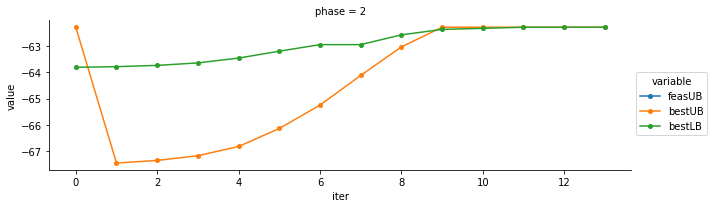

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

xcol = 'iter'
if RELAX_LP:
    df_phase1.loc[:,'phase'] = 1
    df_phase1.loc[:,'feasUB'] = np.nan
    df_phase1.loc[ df_phase1.bestUB>1e6,'bestUB'] = np.nan

df_phase2.loc[:,'phase'] = 2
df_phase2.loc[ df_phase2.feasUB>1e6,'feasUB'] = np.nan
if RELAX_LP:
    dsplot = pd.concat([df_phase1, df_phase2])
else:
    dsplot = df_phase2
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])

g = sns.FacetGrid(dsplot, hue='variable', size=3, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value', marker='o', markersize=4)
g.add_legend()

---

## UB is wrong (lower than LB): was due to keeping previous cuts despite bounds changing

# LagrangeBB: remove cuts from other nodes

for node in lagrangeBB.tree.nodes:
    print(node.problem.yopt, node.value, node.ObjVal)

In [ ]:
def bound_lineage(node):
    print(node.bound_dict)
    if node.parent is not None:
        bound_lineage(node.parent)

In [ ]:
bound_lineage(child1)

In [ ]:
for k,node in enumerate(lagrangeBB.tree.nodes):
    print('-'*50)
    print('node k=%d. ObjVal=%s. value=%s. yopt=%s. Status=%s.'%(k,node.ObjVal,node.value, node.problem.yopt,
                                                                node.problem.model.Status))
    bound_lineage(node)

In [ ]:
node.problem.yopt

In [ ]:
df_phase2

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

xcol = 'iter'
if RELAX_LP:
    df_phase1.loc[:,'phase'] = 1
    df_phase1.loc[:,'feasUB'] = np.nan
    df_phase1.loc[ df_phase1.bestUB>1e6,'bestUB'] = np.nan

df_phase2.loc[:,'phase'] = 2
df_phase2.loc[ df_phase2.feasUB>1e6,'feasUB'] = np.nan
if RELAX_LP:
    dsplot = pd.concat([df_phase1, df_phase2])
else:
    dsplot = df_phase2
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])

g = sns.FacetGrid(dsplot, hue='variable', size=3, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value', marker='o', markersize=4)
g.add_legend()

In [ ]:
objfun = master.model.getObjective()

In [ ]:
for i in [10, 100]: #, 1000, 10000]:
    cons = master.model.getConstrs()[i]
    print("%s %s %s" % (master.model.getRow(cons), cons.Sense, cons.RHS))

for i in range(len(master.model.getConstrs())):
    cons = master.model.getConstrs()[i]
    print("%s %s %s" % (master.model.getRow(cons), cons.Sense, cons.RHS))

In [ ]:
master.model.ObjVal